# Intro 
This notebook is just a prototype for testing several functions and quickly build prototype for AR project. 

This notebook also helps us to gain understanding about the project pipeline.  

Complete source code with documentation at: https://github.com/VinhDevNguyen/CV_Project  

# Mount Drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/do_an_cv

/content/drive/MyDrive/do_an_cv


# Import libraries

In [ ]:
import os
import cv2
import numpy as np
import math
from google.colab.patches import cv2_imshow

# Feature Extraction 
Detect keypoints from given image by using **ORB**

ORB was recommended by OpenCVLab  

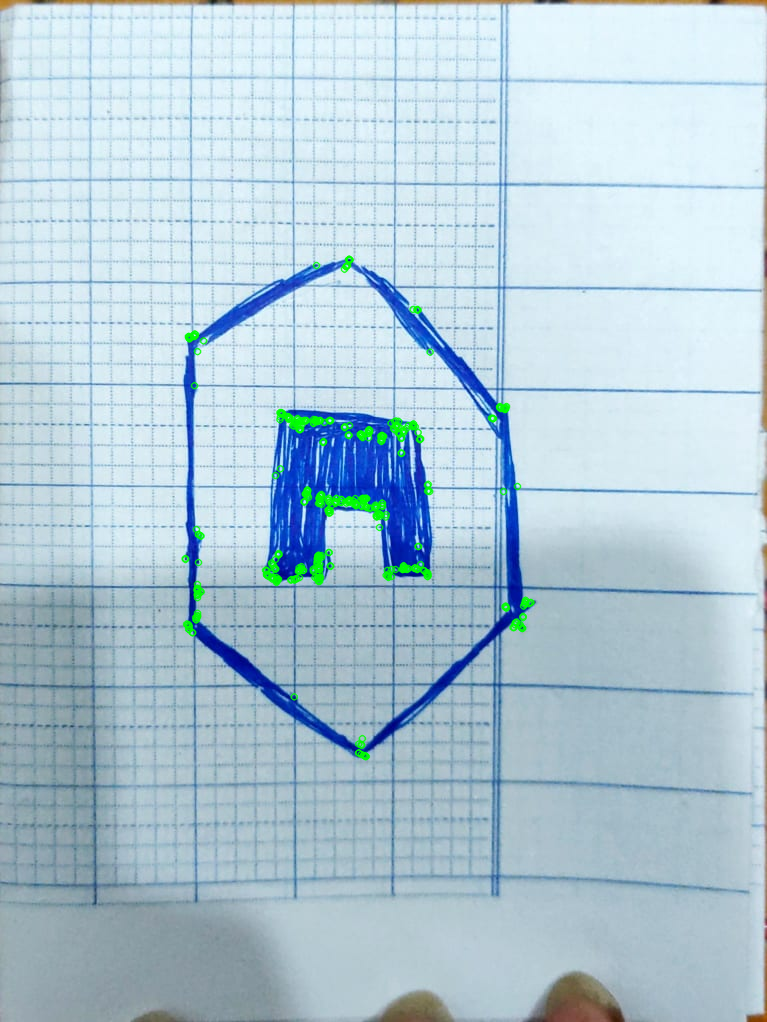

In [ ]:
image = cv2.imread('/content/drive/MyDrive/do_an_cv/model2.jpg') # reference surface 
orb = cv2.ORB_create() # ORB: FAST detector and BRIEF descriptor
kp = orb.detect(image, None)
kp, des = orb.compute(image, kp)

# visualize 
image = cv2.drawKeypoints(image, kp, image, color = (0, 255, 0), flags =0)
cv2_imshow(image)

# Feature Matching
Using brute-force approach  
Using parameter `NORM_HAMMING`(Hamming Distance) as recommended from OpenCV documentation  

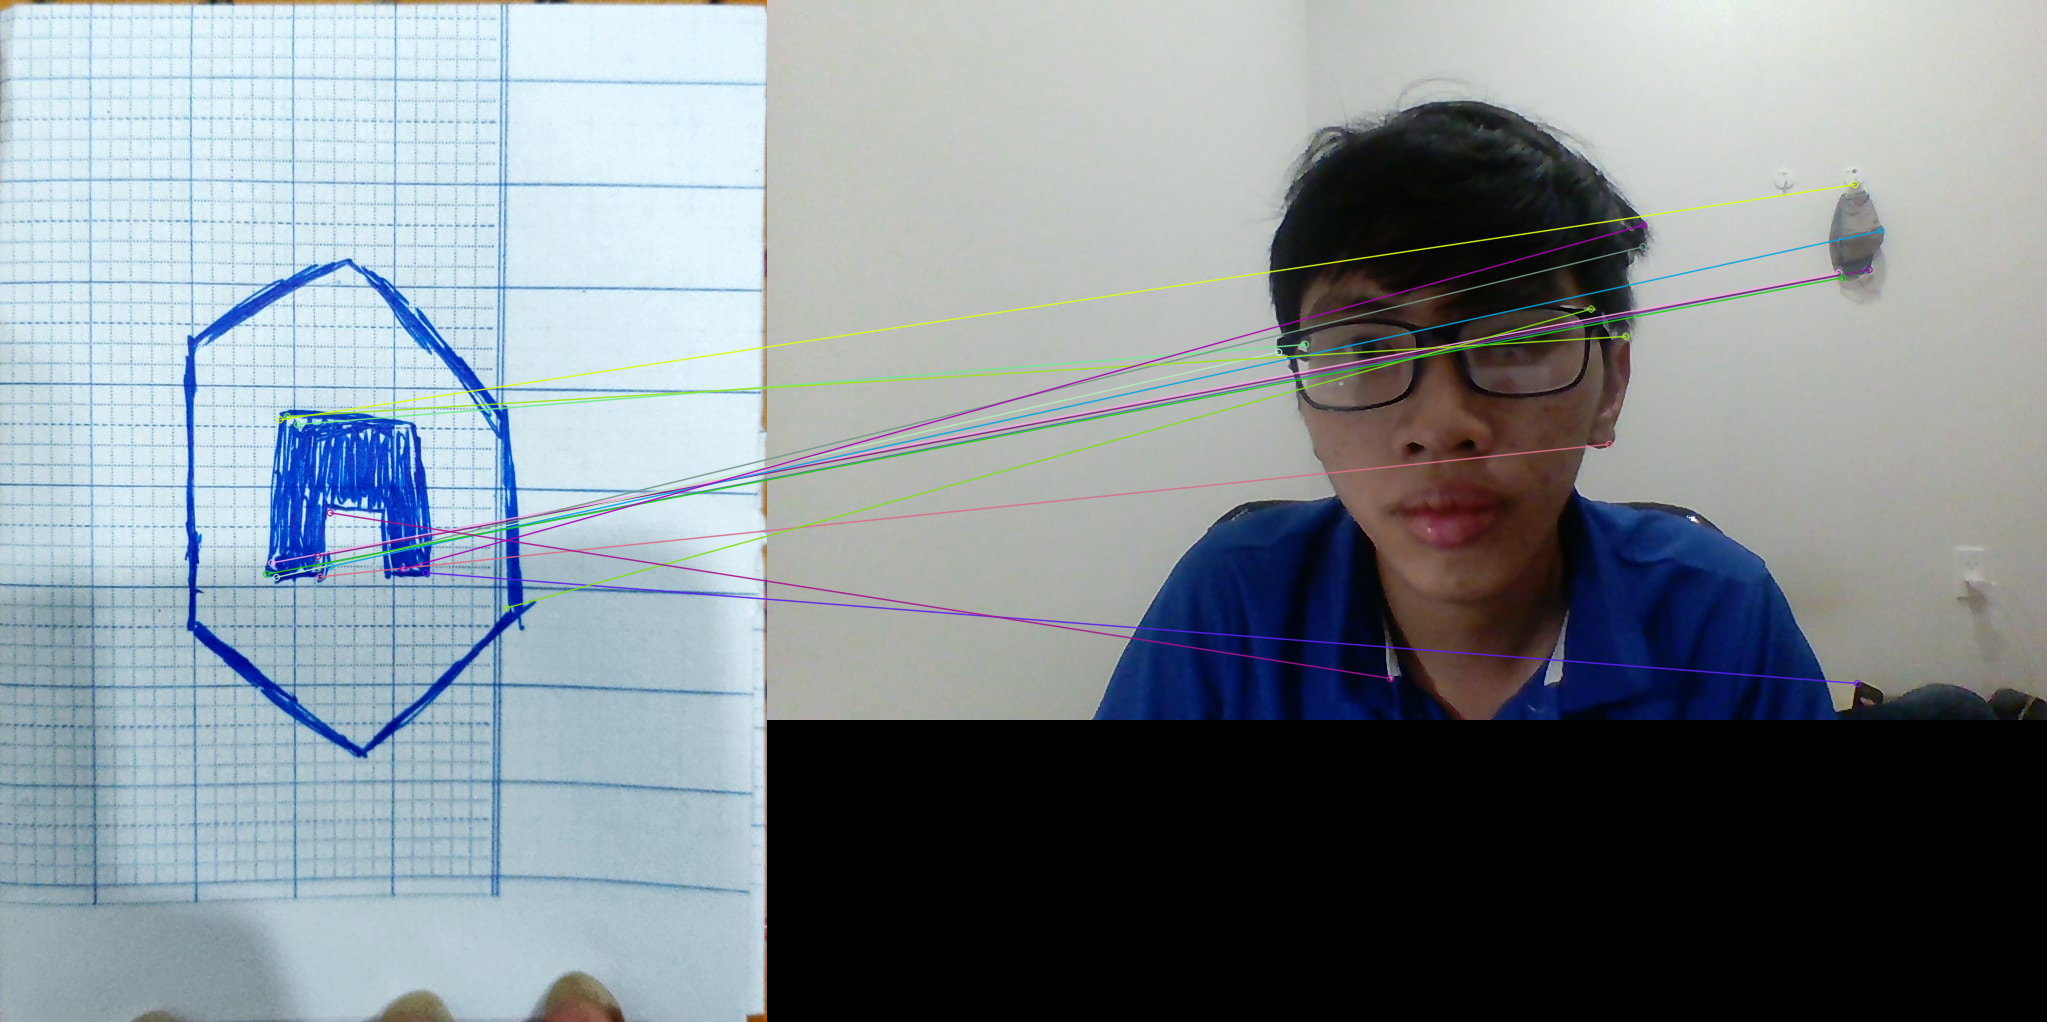

In [ ]:
# load reference surface and image 
model = cv2.imread('/content/drive/MyDrive/do_an_cv/model2.jpg')
cap = cv2.imread('/content/drive/MyDrive/do_an_cv/WIN_20210128_22_26_00_Pro.jpg')

# using ORB 

orb = cv2.ORB_create()
# brute force matcher with HAMMING distance 
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# compute reference surface keypoints and its descriptors  
kp_model, des_model = orb.detectAndCompute(model, None)

# compute image keypoints and its descriptors  
kp_frame, des_frame = orb.detectAndCompute(cap, None)

# return matches between surface and image  
matches = bf.match(des_model, des_frame)
matches = sorted(matches, key= lambda x: x.distance)

# visualize 
image2 = cv2.drawMatches(model, kp_model, cap, kp_frame, matches[:15], 0, flags = 2)
cv2_imshow(image2)

# Homography Estimation with RANSAC 

## Compute Homography

In [ ]:
scr_pts = np.float32([kp_model[m.queryIdx].pt for m in matches]).reshape(-1, 1 ,2)
dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Compute homography using RANSAC 
M, mask = cv2.findHomography(scr_pts, dst_pts, cv2.RANSAC, 5.0)

## Visualized

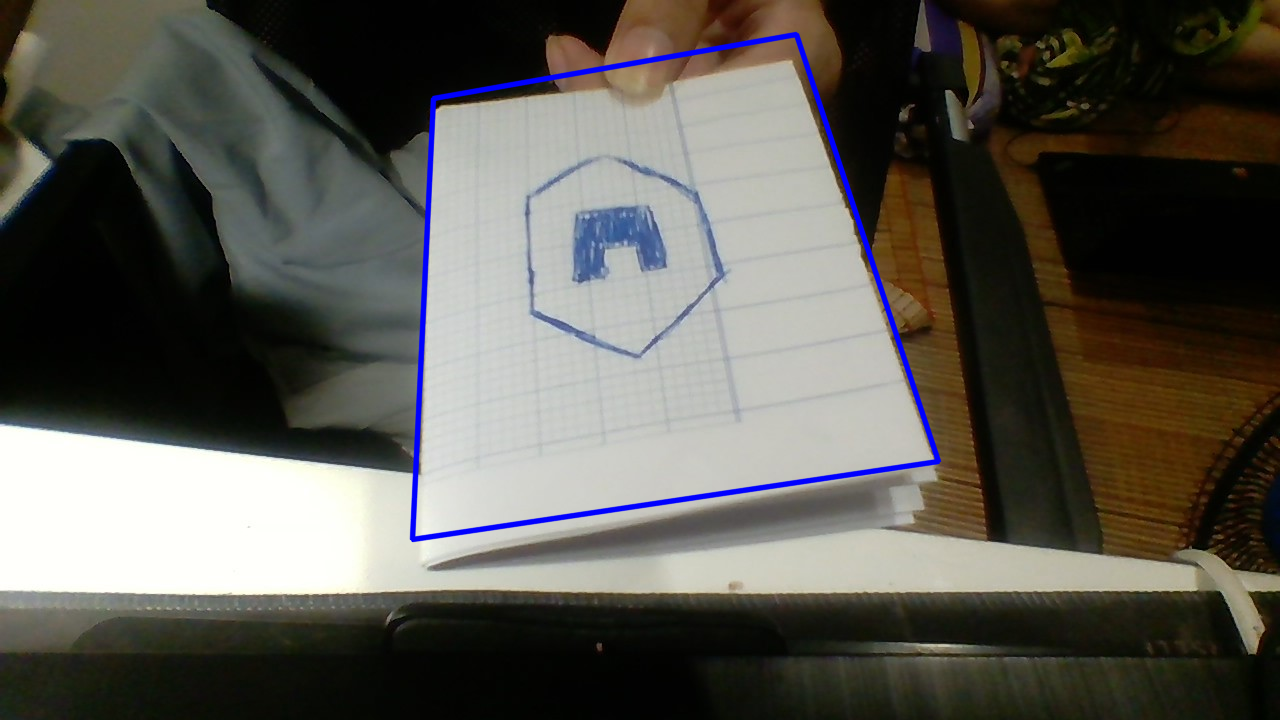

In [ ]:
# Visualize detect surface from image 
h, w = model.shape[:2]
pts = np.float32([[0, 0], [0, h -1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, M)

cap = cv2.polylines(cap, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
cv2_imshow(cap)

# Estimate projection matrix 

## Calibration matrix (Camera calibration matrix) 
The parameters for calibration matrix just base on guesing and works quite well for us. 

Further improve and more precise calculation will be working on. 

Documentation about calibration matrix here: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html

In [ ]:
camera_parameters = np.array([[800, 0, 320], 
                              [0, 800, 240], 
                              [0, 0, 1]])

Here is a example of how to calculate projection matrix  
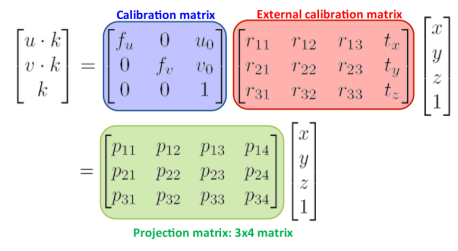

## Projection martrix 
Projection matrix function receive 2 parameters: **camera calibration matrix** and **estimated homography**  

In [ ]:
def projection_matrix(camera_parameters, homography):
    """
    From the camera calibration matrix and the estimated homography
    compute the 3D projection matrix
    """
    # Compute rotation along the x and y axis as well as the translation
    homography = homography * (-1)
    rot_and_transl = np.dot(np.linalg.inv(camera_parameters), homography)
    col_1 = rot_and_transl[:, 0]
    col_2 = rot_and_transl[:, 1]
    col_3 = rot_and_transl[:, 2]
    # normalize vectors
    l = math.sqrt(np.linalg.norm(col_1, 2) * np.linalg.norm(col_2, 2))
    rot_1 = col_1 / l
    rot_2 = col_2 / l
    translation = col_3 / l
    # compute the orthonormal basis
    c = rot_1 + rot_2
    p = np.cross(rot_1, rot_2)
    d = np.cross(c, p)
    rot_1 = np.dot(c / np.linalg.norm(c, 2) + d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_2 = np.dot(c / np.linalg.norm(c, 2) - d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_3 = np.cross(rot_1, rot_2)
    # finally, compute the 3D projection matrix from the model to the current frame
    projection = np.stack((rot_1, rot_2, rot_3, translation)).T
    return np.dot(camera_parameters, projection)

In [ ]:
projection = projection_matrix(camera_parameters, M)

# Render function 

In [ ]:
def render(img, obj, projection, model, color=False):
    vertices = obj.vertices
    scale_matrix = np.eye(3) * 0.5
    h, w = model.shape[:2]

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        points = np.dot(points, scale_matrix)
        points = np.array([[p[0] + w / 2, p[1] + h / 2, p[2]] for p in points])
        dst = cv2.perspectiveTransform(points.reshape(-1, 1, 3), projection)
        imgpts = np.int32(dst)
        if color is False:
            cv2.fillConvexPoly(img, imgpts, (137, 27, 211))
        else:
            color = hex_to_rgb(face[-1])
            color = color[::-1] # reverse
            cv2.fillConvexPoly(img, imgpts, color)

    return img

# Object utilities


## Object class and loader function   

In [ ]:
class OBJ:
    def __init__(self, filename, swapyz=False):
        """Loads a Wavefront OBJ file. """
        self.vertices = []
        self.normals = []
        self.texcoords = []
        self.faces = []
        material = None
        for line in open(filename, "r"):
            if line.startswith('#'): continue
            values = line.split()
            if not values: continue
            if values[0] == 'v':
                v = list(map(float, values[1:4]))
                if swapyz:
                    v = v[0], v[2], v[1]
                self.vertices.append(v)
            elif values[0] == 'vn':
                v = list(map(float, values[1:4]))
                if swapyz:
                    v = v[0], v[2], v[1]
                self.normals.append(v)
            elif values[0] == 'vt':
                self.texcoords.append(map(float, values[1:3]))
            #elif values[0] in ('usemtl', 'usemat'):
                #material = values[1]
            #elif values[0] == 'mtllib':
                #self.mtl = MTL(values[1])
            elif values[0] == 'f':
                face = []
                texcoords = []
                norms = []
                for v in values[1:]:
                    w = v.split('/')
                    face.append(int(w[0]))
                    if len(w) >= 2 and len(w[1]) > 0:
                        texcoords.append(int(w[1]))
                    else:
                        texcoords.append(0)
                    if len(w) >= 3 and len(w[2]) > 0:
                        norms.append(int(w[2]))
                    else:
                        norms.append(0)
                #self.faces.append((face, norms, texcoords, material))
                self.faces.append((face, norms, texcoords))

## Load wolf object 

In [ ]:
obj = OBJ('/content/drive/MyDrive/do_an_cv/wolf.obj', swapyz=True)

In [ ]:
# some info about wavefront object
obj.faces

[([309, 38, 27], [0, 0, 0], [1477, 169, 119]),
 ([224, 174, 432], [0, 0, 0], [1083, 814, 2005]),
 ([450, 190, 274], [0, 0, 0], [2102, 905, 1319]),
 ([511, 191, 197], [0, 0, 0], [2401, 911, 950]),
 ([148, 451, 37], [0, 0, 0], [674, 2108, 167]),
 ([31, 342, 304], [0, 0, 0], [139, 1638, 1451]),
 ([229, 479, 60], [0, 0, 0], [1106, 2225, 217]),
 ([466, 491, 112], [0, 0, 0], [2172, 2299, 503]),
 ([160, 388, 505], [0, 0, 0], [742, 1814, 2372]),
 ([463, 544, 535], [0, 0, 0], [2159, 2572, 2522]),
 ([232, 313, 318], [0, 0, 0], [1116, 1499, 1522]),
 ([433, 189, 191], [0, 0, 0], [2011, 898, 910]),
 ([500, 534, 104], [0, 0, 0], [2345, 2515, 456]),
 ([476, 484, 488], [0, 0, 0], [2213, 2254, 2282]),
 ([189, 433, 447], [0, 0, 0], [897, 2010, 2084]),
 ([153, 372, 241], [0, 0, 0], [702, 1746, 1164]),
 ([410, 159, 185], [0, 0, 0], [1906, 736, 876]),
 ([332, 113, 346], [0, 0, 0], [1595, 509, 1659]),
 ([534, 151, 410], [0, 0, 0], [2514, 691, 1905]),
 ([108, 441, 188], [0, 0, 0], [479, 2054, 893]),
 ([325, 

# Model projection

In [ ]:
frame = render(cap, obj, projection, model, color = False)

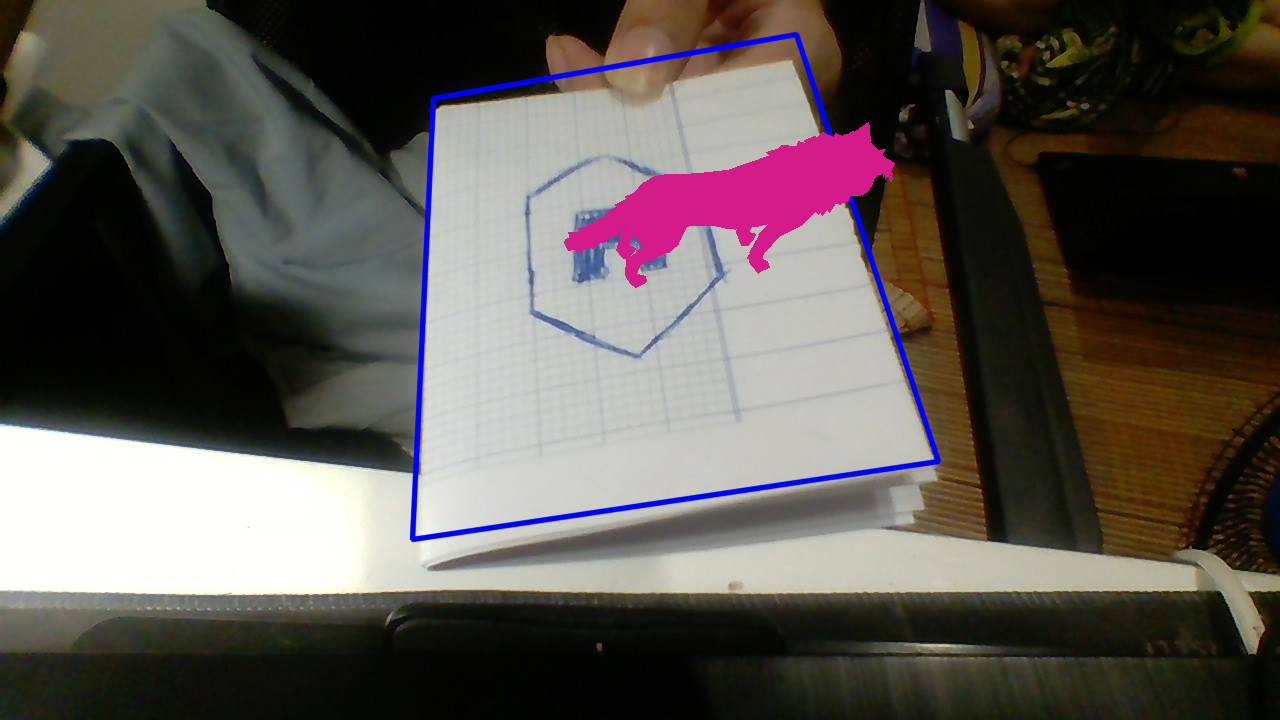

In [ ]:
cv2_imshow(frame)

# Run with one cell

In [ ]:
model = cv2.imread('/content/drive/MyDrive/do_an_cv/model2.jpg')
cap = cv2.imread('/content/drive/MyDrive/do_an_cv/WIN_20210108_23_27_47_Pro.jpg')
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

kp_model, des_model = orb.detectAndCompute(model, None)
kp_frame, des_frame = orb.detectAndCompute(cap, None)

matches = bf.match(des_model, des_frame)

matches = sorted(matches, key= lambda x: x.distance)

image2 = cv2.drawMatches(model, kp_model, cap, kp_frame, matches[:15], 0, flags = 2)
cv2_imshow(image2)
scr_pts = np.float32([kp_model[m.queryIdx].pt for m in matches]).reshape(-1, 1 ,2)
dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

M, mask = cv2.findHomography(scr_pts, dst_pts, cv2.RANSAC, 5.0)
h, w = model.shape[:2]
pts = np.float32([[0, 0], [0, h -1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, M)

cap = cv2.polylines(cap, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
cv2_imshow(cap)
obj = OBJ('/content/drive/MyDrive/do_an_cv/wolf.obj', swapyz=True)
frame = render(cap, obj, projection, model, color = False)
cv2_imshow(frame)

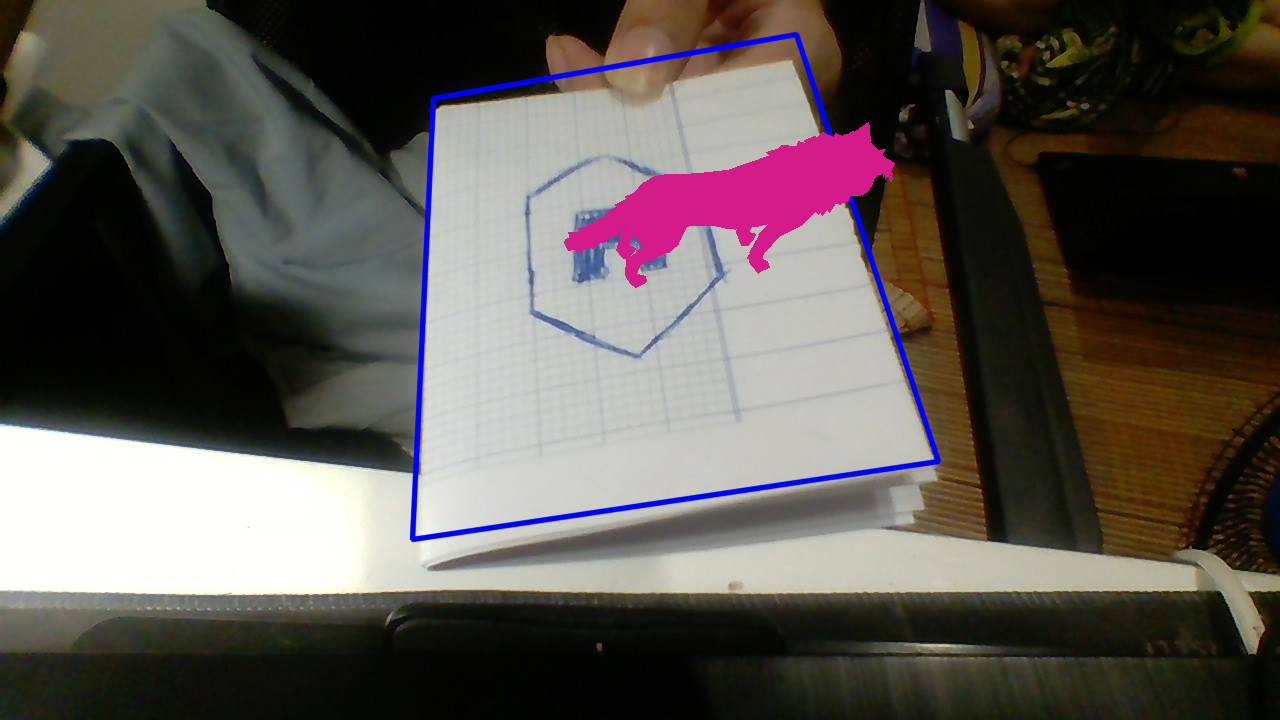

In [ ]:
cv2_imshow(frame)